In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000.,
               y_start=.5394, T=100, dt=1):
    Et = np.zeros(int(T/dt)+1)
    yt = np.zeros(int(T/dt)+1)
    ht = np.zeros(int(T/dt)+1)
    gt = np.zeros((len(g_grid), int(T/dt)+1))
    for i in range(int(T/dt)+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ*dt
    return Et, yt, ht, gt

## Solve HJB

In [3]:
# Intensity parameter
τ = .25

r1 = 19.5001
r0 = .4

# Robustness parameters
ξ_b = 100000.
ξ_p = 5.
ξ_a = 1./100

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.5

# Grid setting
ϵ = 2.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc+1]

In [ ]:
# Parallelly solve ODE
model_args_list = []
model_list = []

for i in range(n_model):
    temp_list = []
    for y_jump in y_grid_tilde:
        temp = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_a, γ_1, γ_2, γ_2p[i], y_jump)
        temp_list.append((y_grid_long, temp, None, ϵ, 1e-8, 2000, False))
    model_args_list.append(temp_list)

for i in range(n_model):
    print('-----Solving model ' + str(i) + '-----')
    temp_res = ode_y_parallel(model_args_list[i])
    model_list.append(temp_res)

In [4]:
import pickle

with open('model_list.pickle', 'rb') as handle:
    model_list = pickle.load(handle)

In [5]:
# Prepare ϕ_m
ϕ_m = np.zeros((n_model, len(y_grid_short)))
e_m = np.zeros((n_model, len(y_grid_short)))
for i in range(len(y_grid_tilde)):
    for j in range(n_model):
        ϕ_m[j, y_bar_lower_loc+i] = model_list[j][i]['v0'][y_bar_lower_loc+i]
        e_m[j, y_bar_lower_loc+i] = model_list[j][i]['e_tilde'][y_bar_lower_loc+i]

# Prepare v_guess
v_guess = np.average(np.array([model_list[0][-1]['v0'][:y_bar_upper_loc+1],
                               model_list[-1][-1]['v0'][:y_bar_upper_loc+1]]),
                     weights=np.array([0.5, 0.5]), axis=0)

In [31]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, τ = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = - η * (y_grid + y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

#     intensity = - r0 * (np.exp(- r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
#                 + 0 * (y_grid < y_bar_lower)
    intensity = 0.75 * (y_grid - 1.5) * (y_grid > 1.5) + 300 * (y_grid - 1.9)**2 * (y_grid > 1.9)
    bc = -ξ_2m * np.log(np.sum(πd_o[:, -1] * np.exp(-1./ξ_2m * ϕ_i[:, -1])))

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5
 
        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)- np.exp(-1./ξ_2m * v0)) \
#                 / np.exp(-1./ξ_2m * v0)


        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + intensity * np.sum(g * πd_o * (ϕ_m - v0), axis=0)\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)


#         g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

#         A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
#         B = e_tilde * np.sum(πc*θ, axis=0)
#         C = .5 * σ_y**2 * e_tilde**2
#         D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
#             + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
#             + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
#             + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, bc), (False, True))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [32]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_b, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, τ)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=2000, print_all=True)

Iteration 1: LHS Error: 3.7683914702361405; RHS Error 5.945103614099956
Iteration 2: LHS Error: 3.7855373047050658; RHS Error 3.9271381479284897
Iteration 3: LHS Error: 3.741689216810515; RHS Error 4.1935483378287355
Iteration 4: LHS Error: 3.6330630617280852; RHS Error 3.670520950964544
Iteration 5: LHS Error: 3.3147747719937004; RHS Error 3.8536241564885922
Iteration 6: LHS Error: 3.1132603035219217; RHS Error 3.1570776316006715
Iteration 7: LHS Error: 2.7650754749156086; RHS Error 3.2590710757869745
Iteration 8: LHS Error: 2.564396356562015; RHS Error 2.631706567141985
Iteration 9: LHS Error: 2.2716278027169; RHS Error 2.688665119498932
Iteration 10: LHS Error: 2.080036635535853; RHS Error 2.1683043298856504
Iteration 11: LHS Error: 1.8214520311117346; RHS Error 2.165624596599317
Iteration 12: LHS Error: 1.6591649996019795; RHS Error 1.7511607445806108
Iteration 13: LHS Error: 1.4640781883204554; RHS Error 1.7351441394543865
Iteration 14: LHS Error: 1.3342349091074688; RHS Error 1.4

Iteration 231: LHS Error: 0.00029424080338547043; RHS Error 0.03647183430788287
Iteration 232: LHS Error: 0.00026483231445073585; RHS Error 0.03644076003331162
Iteration 233: LHS Error: 0.00023603787472570303; RHS Error 0.03646242972220494
Iteration 234: LHS Error: 0.00021231869181903562; RHS Error 0.036450712339331184
Iteration 235: LHS Error: 0.00018873671187247254; RHS Error 0.036455585001973975
Iteration 236: LHS Error: 0.00016965534152735273; RHS Error 0.036453701402064206
Iteration 237: LHS Error: 0.00015033294509159134; RHS Error 0.0364541554559546
Iteration 238: LHS Error: 0.00013508322704502973; RHS Error 0.0364549024155045
Iteration 239: LHS Error: 0.00012035896531692458; RHS Error 0.036453895672717826
Iteration 240: LHS Error: 0.0001071259901817001; RHS Error 0.03645508613247958
Iteration 241: LHS Error: 9.43776343893532e-05; RHS Error 0.036451534993506236
Iteration 242: LHS Error: 8.464997420798426e-05; RHS Error 0.03646345851174808
Iteration 243: LHS Error: 7.5310721333821

Iteration 348: LHS Error: 3.228257912066268e-05; RHS Error 0.03645327065466218
Iteration 349: LHS Error: 5.204809073980354e-05; RHS Error 0.036456069927014674
Iteration 350: LHS Error: 3.2747279809314245e-05; RHS Error 0.03645429048657979
Iteration 351: LHS Error: 6.678981750452007e-05; RHS Error 0.03645233932156015
Iteration 352: LHS Error: 6.550852177700239e-05; RHS Error 0.03645586154764292
Iteration 353: LHS Error: 3.0176186994856913e-05; RHS Error 0.03645720398098075
Iteration 354: LHS Error: 5.7618574830137215e-05; RHS Error 0.036451511248856414
Iteration 355: LHS Error: 4.5545099947252865e-05; RHS Error 0.03645589207548347
Iteration 356: LHS Error: 3.527537712225137e-05; RHS Error 0.036448724449349414
Iteration 357: LHS Error: 5.4203258570723056e-05; RHS Error 0.03646024386537471
Iteration 358: LHS Error: 4.4611432872460055e-05; RHS Error 0.036458578949328885
Iteration 359: LHS Error: 3.467213834790206e-05; RHS Error 0.03644463333815252
Iteration 360: LHS Error: 5.78069194477337

Iteration 471: LHS Error: 2.0625952045660867e-05; RHS Error 0.036453327616130585
Iteration 472: LHS Error: 2.306417474345901e-05; RHS Error 0.036453842778327784
Iteration 473: LHS Error: 6.460966895793785e-05; RHS Error 0.036456389999122235
Iteration 474: LHS Error: 4.893884413981198e-05; RHS Error 0.03645680912288686
Iteration 475: LHS Error: 5.4781764675132516e-05; RHS Error 0.03645268701503148
Iteration 476: LHS Error: 4.5338119381010955e-05; RHS Error 0.03645819695172918
Iteration 477: LHS Error: 3.93780622394424e-05; RHS Error 0.036452284688617345
Iteration 478: LHS Error: 2.5812139269776324e-05; RHS Error 0.03645608327324697
Iteration 479: LHS Error: 6.24744023171031e-05; RHS Error 0.03645105267670998
Iteration 480: LHS Error: 3.0079624522644233e-05; RHS Error 0.03645586930306741
Iteration 481: LHS Error: 4.960467994269413e-05; RHS Error 0.03645426290042923
Iteration 482: LHS Error: 3.709465365436815e-05; RHS Error 0.036455875437412175
Iteration 483: LHS Error: 3.35309507777104e-

Iteration 597: LHS Error: 5.851581422727792e-05; RHS Error 0.03646094121784007
Iteration 598: LHS Error: 5.2259207632743276e-05; RHS Error 0.03645670512318076
Iteration 599: LHS Error: 3.079579197817761e-05; RHS Error 0.036444471204950646
Iteration 600: LHS Error: 5.362785113161017e-05; RHS Error 0.03645623384146168
Iteration 601: LHS Error: 3.439226190007916e-05; RHS Error 0.03645404997673425
Iteration 602: LHS Error: 3.44215292097938e-05; RHS Error 0.03645200432278073
Iteration 603: LHS Error: 2.964108314662539e-05; RHS Error 0.0364464994061693
Iteration 604: LHS Error: 5.314753963051033e-05; RHS Error 0.0364551498703381
Iteration 605: LHS Error: 4.3533806052542534e-05; RHS Error 0.03645941925489179
Iteration 606: LHS Error: 3.594144264679189e-05; RHS Error 0.03644297411930548
Iteration 607: LHS Error: 1.8762163565333445e-05; RHS Error 0.03645768993913171
Iteration 608: LHS Error: 3.7858138692975496e-05; RHS Error 0.03645162949857482
Iteration 609: LHS Error: 2.3634192461985393e-05; 

Iteration 714: LHS Error: 5.7911678763178376e-05; RHS Error 0.036459208921070546
Iteration 715: LHS Error: 6.091187350687477e-05; RHS Error 0.036464054240186304
Iteration 716: LHS Error: 3.612481977595394e-05; RHS Error 0.03645063181551582
Iteration 717: LHS Error: 2.668564970775833e-05; RHS Error 0.03645524478808688
Iteration 718: LHS Error: 3.20636202507385e-05; RHS Error 0.03645341450104908
Iteration 719: LHS Error: 1.3177522996288271e-05; RHS Error 0.03644858671170357
Iteration 720: LHS Error: 6.989092664458352e-05; RHS Error 0.03644763621505251
Iteration 721: LHS Error: 4.4021502985838734e-05; RHS Error 0.03645663300581478
Iteration 722: LHS Error: 4.372624106513401e-05; RHS Error 0.036455954295412665
Iteration 723: LHS Error: 3.355580412112147e-05; RHS Error 0.03645762467642059
Iteration 724: LHS Error: 2.3761340413153142e-05; RHS Error 0.03645427274804008
Iteration 725: LHS Error: 4.875055279957019e-05; RHS Error 0.03645245026098122
Iteration 726: LHS Error: 3.492048034317574e-0

Iteration 833: LHS Error: 3.6412767282778535e-05; RHS Error 0.03645167896463983
Iteration 834: LHS Error: 3.185738765681956e-05; RHS Error 0.03644945719684463
Iteration 835: LHS Error: 5.456791279431772e-05; RHS Error 0.036455149399456765
Iteration 836: LHS Error: 2.8381277201283694e-05; RHS Error 0.0364603896072843
Iteration 837: LHS Error: 6.223648322639663e-05; RHS Error 0.03645065259396789
Iteration 838: LHS Error: 5.040627793789776e-05; RHS Error 0.036457728352716476
Iteration 839: LHS Error: 3.570734448146706e-05; RHS Error 0.036451647128705404
Iteration 840: LHS Error: 5.95530309375758e-05; RHS Error 0.036448739004456554
Iteration 841: LHS Error: 4.674925556044651e-05; RHS Error 0.03645553158876813
Iteration 842: LHS Error: 4.6397876431875096e-05; RHS Error 0.036450082266494224
Iteration 843: LHS Error: 2.9275498294900615e-05; RHS Error 0.03645895420104642
Iteration 844: LHS Error: 1.55591260002641e-05; RHS Error 0.036451309034799796
Iteration 845: LHS Error: 1.2646599384269486e

Iteration 958: LHS Error: 3.5175502253653734e-05; RHS Error 0.03645904365782659
Iteration 959: LHS Error: 4.322479723975481e-05; RHS Error 0.03644677700101338
Iteration 960: LHS Error: 4.8710872291080065e-05; RHS Error 0.03645950756615314
Iteration 961: LHS Error: 4.605139853350315e-05; RHS Error 0.036457935914607456
Iteration 962: LHS Error: 3.403574784183183e-05; RHS Error 0.0364444207049575
Iteration 963: LHS Error: 1.8486226445485476e-05; RHS Error 0.036457465693889586
Iteration 964: LHS Error: 4.017384534904522e-05; RHS Error 0.0364523345326479
Iteration 965: LHS Error: 5.808174958840673e-05; RHS Error 0.0364571368415446
Iteration 966: LHS Error: 2.1958393473700544e-05; RHS Error 0.03644247086092807
Iteration 967: LHS Error: 6.16254346668954e-05; RHS Error 0.03645868786049644
Iteration 968: LHS Error: 4.3605108347055666e-05; RHS Error 0.036457748552997535
Iteration 969: LHS Error: 2.5992998310520044e-05; RHS Error 0.036442472546856626
Iteration 970: LHS Error: 5.22143716933654e-05

Iteration 1080: LHS Error: 2.5119976157284007e-05; RHS Error 0.036452059262364916
Iteration 1081: LHS Error: 3.8935162054665184e-05; RHS Error 0.03645497070619371
Iteration 1082: LHS Error: 6.185793284696484e-05; RHS Error 0.036442080329007746
Iteration 1083: LHS Error: 4.143347127388841e-05; RHS Error 0.0364484609706221
Iteration 1084: LHS Error: 1.6584698773663975e-05; RHS Error 0.03645560023790921
Iteration 1085: LHS Error: 9.99293079084751e-06; RHS Error 0.03645372092785084
Iteration 1086: LHS Error: 6.85238771771235e-05; RHS Error 0.0364522879922094
Iteration 1087: LHS Error: 3.963356299352405e-05; RHS Error 0.036445391582271294
Iteration 1088: LHS Error: 1.806553659786103e-05; RHS Error 0.03645690999850831
Iteration 1089: LHS Error: 5.937570293082506e-05; RHS Error 0.03645043302430395
Iteration 1090: LHS Error: 3.969788205887559e-05; RHS Error 0.03644778610697178
Iteration 1091: LHS Error: 1.852512274705398e-05; RHS Error 0.03645533387236001
Iteration 1092: LHS Error: 5.628861173

Iteration 1202: LHS Error: 5.013920519575388e-05; RHS Error 0.03645545726522838
Iteration 1203: LHS Error: 3.7336077582633687e-05; RHS Error 0.03645408124579688
Iteration 1204: LHS Error: 3.79914791580338e-05; RHS Error 0.03645228999468121
Iteration 1205: LHS Error: 2.1483080291762047e-05; RHS Error 0.0364527567900321
Iteration 1206: LHS Error: 9.042749469953537e-05; RHS Error 0.036452152882486114
Iteration 1207: LHS Error: 4.362038694774584e-05; RHS Error 0.03645641946465959
Iteration 1208: LHS Error: 3.7045505763000364e-05; RHS Error 0.03645533124364729
Iteration 1209: LHS Error: 4.0407110845991356e-05; RHS Error 0.03644857984392333
Iteration 1210: LHS Error: 4.937940855975764e-05; RHS Error 0.03645811312074423
Iteration 1211: LHS Error: 4.365610423512356e-05; RHS Error 0.036458728849269276
Iteration 1212: LHS Error: 3.41339864344814e-05; RHS Error 0.0364440862017817
Iteration 1213: LHS Error: 6.047956959487344e-05; RHS Error 0.03645775875420064
Iteration 1214: LHS Error: 2.777890225

Iteration 1325: LHS Error: 5.407557758796422e-05; RHS Error 0.03644318289838214
Iteration 1326: LHS Error: 4.630211435555087e-05; RHS Error 0.036466273829998334
Iteration 1327: LHS Error: 5.300618753345532e-05; RHS Error 0.03644087766055165
Iteration 1328: LHS Error: 4.3303501602781624e-05; RHS Error 0.03645892261078157
Iteration 1329: LHS Error: 3.858720800531401e-05; RHS Error 0.036447412991793944
Iteration 1330: LHS Error: 3.5331479949718414e-05; RHS Error 0.03645899339829506
Iteration 1331: LHS Error: 4.354215398785777e-05; RHS Error 0.03644674763670207
Iteration 1332: LHS Error: 4.879025291384953e-05; RHS Error 0.036459358959343276
Iteration 1333: LHS Error: 4.579297228482493e-05; RHS Error 0.03645801033382579
Iteration 1334: LHS Error: 3.4318380594228204e-05; RHS Error 0.03644442360556077
Iteration 1335: LHS Error: 1.8653014508762666e-05; RHS Error 0.03645749317055886
Iteration 1336: LHS Error: 4.0278416626460256e-05; RHS Error 0.036452323378829546
Iteration 1337: LHS Error: 5.81

Iteration 1447: LHS Error: 6.462594866819826e-05; RHS Error 0.03644673443972132
Iteration 1448: LHS Error: 5.541215800489163e-05; RHS Error 0.036467288985554534
Iteration 1449: LHS Error: 3.539819525824606e-05; RHS Error 0.03644768260732996
Iteration 1450: LHS Error: 4.508565505542683e-05; RHS Error 0.03645498741514962
Iteration 1451: LHS Error: 2.2901596838986737e-05; RHS Error 0.03645257985202275
Iteration 1452: LHS Error: 2.92979148534267e-05; RHS Error 0.03645243598077492
Iteration 1453: LHS Error: 2.1597221369934472e-05; RHS Error 0.036452998830002976
Iteration 1454: LHS Error: 2.685502949262286e-05; RHS Error 0.03645222098269947
Iteration 1455: LHS Error: 3.900784080509978e-05; RHS Error 0.03644842510241903
Iteration 1456: LHS Error: 2.8566647032463033e-05; RHS Error 0.03645406690851888
Iteration 1457: LHS Error: 5.9432601592926404e-05; RHS Error 0.03644528487522193
Iteration 1458: LHS Error: 3.6741731045841775e-05; RHS Error 0.03645948639076377
Iteration 1459: LHS Error: 4.52878

Iteration 1570: LHS Error: 4.4419381583366e-05; RHS Error 0.03645892447786119
Iteration 1571: LHS Error: 3.522846236742039e-05; RHS Error 0.03644366167268934
Iteration 1572: LHS Error: 1.8685981319183087e-05; RHS Error 0.036457612811205124
Iteration 1573: LHS Error: 3.753838013789701e-05; RHS Error 0.03645179416906727
Iteration 1574: LHS Error: 2.4022116513588987e-05; RHS Error 0.03645709109896337
Iteration 1575: LHS Error: 7.460437422174282e-05; RHS Error 0.036452984320416416
Iteration 1576: LHS Error: 3.28000603904699e-05; RHS Error 0.03645866769599494
Iteration 1577: LHS Error: 3.213678048066826e-05; RHS Error 0.036454914579322005
Iteration 1578: LHS Error: 4.5032932942695725e-05; RHS Error 0.03645495630101776
Iteration 1579: LHS Error: 4.262603091367834e-05; RHS Error 0.03644847939692712
Iteration 1580: LHS Error: 5.625729588973338e-05; RHS Error 0.036456515505167986
Iteration 1581: LHS Error: 3.643705724407087e-05; RHS Error 0.03645500958451447
Iteration 1582: LHS Error: 3.0699420

Iteration 1691: LHS Error: 2.583014331661304e-05; RHS Error 0.03644918513627887
Iteration 1692: LHS Error: 5.387147827706773e-05; RHS Error 0.036453302774698916
Iteration 1693: LHS Error: 3.8619251409022226e-05; RHS Error 0.03645228962971573
Iteration 1694: LHS Error: 4.8696136291020986e-05; RHS Error 0.03645315359271367
Iteration 1695: LHS Error: 6.141504661338892e-05; RHS Error 0.03645202352034396
Iteration 1696: LHS Error: 3.8618453496841454e-05; RHS Error 0.036456234025183706
Iteration 1697: LHS Error: 2.808727216574436e-05; RHS Error 0.03645112749526404
Iteration 1698: LHS Error: 6.36189787423802e-05; RHS Error 0.036453007022032274
Iteration 1699: LHS Error: 2.9813128698735758e-05; RHS Error 0.0364551736703099
Iteration 1700: LHS Error: 3.615977486026711e-05; RHS Error 0.03645509794497381
Iteration 1701: LHS Error: 2.9700776329105727e-05; RHS Error 0.036446541194550555
Iteration 1702: LHS Error: 5.143889917733069e-05; RHS Error 0.03645655629630545
Iteration 1703: LHS Error: 3.0941

Iteration 1813: LHS Error: 4.9828721900235795e-05; RHS Error 0.036460498229934565
Iteration 1814: LHS Error: 4.575053048513911e-05; RHS Error 0.036457266667481655
Iteration 1815: LHS Error: 3.506590816934607e-05; RHS Error 0.03644593182456257
Iteration 1816: LHS Error: 5.725769302258876e-05; RHS Error 0.03645715604776974
Iteration 1817: LHS Error: 2.6515110920610763e-05; RHS Error 0.03645940738205958
Iteration 1818: LHS Error: 5.928480009334547e-05; RHS Error 0.03645136028835573
Iteration 1819: LHS Error: 5.6402535856453495e-05; RHS Error 0.036457466741088164
Iteration 1820: LHS Error: 5.62528210142077e-05; RHS Error 0.036451886488430424
Iteration 1821: LHS Error: 5.326376520123355e-05; RHS Error 0.036460438719497806
Iteration 1822: LHS Error: 3.304601377190908e-05; RHS Error 0.036451047911603876
Iteration 1823: LHS Error: 3.269786195914115e-05; RHS Error 0.03645071638832209
Iteration 1824: LHS Error: 5.025779922374074e-05; RHS Error 0.036454248616549126
Iteration 1825: LHS Error: 3.01

Iteration 1937: LHS Error: 4.4387632914755226e-05; RHS Error 0.036461026693240126
Iteration 1938: LHS Error: 5.4503029691177485e-05; RHS Error 0.036448778207936024
Iteration 1939: LHS Error: 4.998296901337351e-05; RHS Error 0.03645945795763829
Iteration 1940: LHS Error: 6.373894596434226e-05; RHS Error 0.036451891786548715
Iteration 1941: LHS Error: 3.396817982999345e-05; RHS Error 0.03646297780616814
Iteration 1942: LHS Error: 5.449952070613051e-05; RHS Error 0.036449012492716266
Iteration 1943: LHS Error: 2.6159501013089947e-05; RHS Error 0.03645633100853395
Iteration 1944: LHS Error: 7.205449900954397e-05; RHS Error 0.03645041323665433
Iteration 1945: LHS Error: 4.128660036761822e-05; RHS Error 0.036457111663970004
Iteration 1946: LHS Error: 5.445551069413468e-05; RHS Error 0.0364497586189806
Iteration 1947: LHS Error: 5.6115482016755314e-05; RHS Error 0.03646841210395768
Iteration 1948: LHS Error: 4.7998122781583996e-05; RHS Error 0.036453599224620735
Iteration 1949: LHS Error: 3.1

## Simulation

In [33]:
e_grid_no_jump = model_res['e_tilde']
e_grid_jump_list = []
for i in range(n_model):
    temp = np.array([model['e_tilde'] for model in model_list[i]])
    e_grid_jump_list.append(temp)
e_grid_jump = np.array(e_grid_jump_list)

In [34]:
def simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                        θ, y0, y_bar_lower, y_bar_upper, r0, r1, τ, damage_prob, γ_2p, n_model, T=100):
    """
    y_grid : (N,) ndarray
    e_grid_no_jump : (N,) ndarray
    e_grid_jump : (n_model, M, N) ndarray
        e.g., e_grid[0, i], e_grid[1, i] and e_grid[2, i] are the emissions conditional
            on low, high and extreme damages when jump occurrs at y_grid_tilde[i].
    """
    et_paths = []
    yt_paths = []
    γ2pt_paths = []
    paths_prob = []

    yt_pre_jump = np.zeros(int(T/τ)+1)
    et_pre_jump = np.zeros(int(T/τ)+1)
    γ2pt_pre_jump = np.ones(int(T/τ)+1) * (-1) # -1 if γ_2p is not revealed        
    t_count = 0

    # path piror to y_bar_lower
    while y0 <= y_bar_lower:
        et_pre_jump[t_count] = np.interp(y0, y_grid_short, e_grid_no_jump)
        yt_pre_jump[t_count] = y0
        y0 = y0 + et_pre_jump[t_count] * θ * τ
        t_count += 1

    # add n_model paths at every time point
    no_jump_prob = 1.
    for t in range(t_count, int(T/τ)+1):
        if y0 < y_bar_upper:
            intensity = 0.75 * (y0 - 1.5) * (y0 > 1.5) + 300 * (y0 - 1.9)**2 * (y0 > 1.9)
            jump_prob = τ * intensity
            for i in range(n_model):
                # compute unconditional prob
                jump_prob_to_i = damage_prob[i] * jump_prob * no_jump_prob
                paths_prob.append(jump_prob_to_i)
                # compute path
                yt = yt_pre_jump.copy()
                et = et_pre_jump.copy()
                γ2pt = γ2pt_pre_jump.copy()
                for j in range(t_count, t):
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt[j], y_grid_short, e_grid_no_jump)
                jump_loc = find_nearest_value(y_grid_tilde, yt[t_count]+et[t_count]*θ*τ)
                e_grid_realized = e_grid_jump[i, jump_loc]
                for j in range(t, int(T/τ)+1):
                    γ2pt[j] = γ_2p[i]
                    yt[j] = yt[j-1] + et[j-1] * θ * τ
                    et[j] = np.interp(yt[j], y_grid_long, e_grid_realized)
                et_paths.append(et)
                yt_paths.append(yt)
                γ2pt_paths.append(γ2pt)
            no_jump_prob *= (1.-jump_prob)
        e_no_jump = np.interp(y0, y_grid_short, e_grid_no_jump)
        y0 = y0 + e_no_jump * θ * τ

    return np.array(et_paths), np.array(yt_paths), np.array(γ2pt_paths), np.array(paths_prob)

In [35]:
et_paths, yt_paths, γ2pt_paths, paths_prob = simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
                           np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
                           r1=r1, τ=τ, damage_prob=damage_setting['πd_o'], γ_2p=damage_setting['γ_2p'], n_model=n_model, T=120)

In [36]:
# et_paths_1, yt_paths_1, γ2pt_paths_1, paths_prob_1 = simulation_prob(y_grid_short, y_grid_long, y_grid_tilde, e_grid_no_jump, e_grid_jump,
#                            np.mean(model_res['θ']), y0=1.1, y_bar_lower=y_bar_lower, y_bar_upper=y_bar_upper, r0=r0,
#                            r1=r1, τ=1., damage_prob=damage_setting['πd_o'], γ_2p=damage_setting['γ_2p'], n_model=n_model, T=120)

In [37]:
et_no_jump, yt_no_jump, _, _ = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=91, dt=τ)

Text(0.5, 0, 'Years')

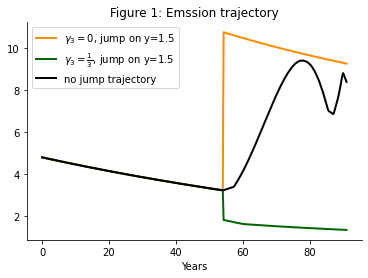

In [38]:
T = 91
time_periods = np.arange(0, T+τ, τ)
plt.plot(time_periods, et_paths[0][:int(T/τ)+1], color='darkorange', linewidth='2', label=r'$\gamma_3 = 0$, jump on y=1.5')
plt.plot(time_periods, et_paths[n_model-1][:int(T/τ)+1], color='darkgreen', linewidth='2', label=r'$\gamma_3 = \frac{1}{3}$, jump on y=1.5')
plt.plot(time_periods, et_no_jump, color='black', linewidth='2', label='no jump trajectory')
plt.legend()
plt.title('Figure 1: Emssion trajectory')
plt.xlabel('Years')
# plt.savefig('fig_1.pdf')

In [ ]:
plt.plot(model_res['y_grid'], e_grid_no_jump)

In [ ]:
plt.plot(model_res['y_grid'], np.average(np.exp(-1./ξ_p*ϕ_m), weights=πd_o, axis=0))

In [ ]:
# Compute no jump probability
no_jump_prob = np.ones_like(yt_no_jump)
for t in range(no_jump_prob.shape[0]):
    y = yt_no_jump[t]
    if y > y_bar_lower:
#         intensity = - r0 * (np.exp(- r1 / 2. * (y-y_bar_lower)**2) - 1.)
        intensity = 0.75 * (y - 1.5) * (y > 1.5)\
                    + 300 * (y - 1.9)**2 * (y > 1.9)
        no_jump_prob[t] = (1 - intensity*τ) * no_jump_prob[t-1]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(time_periods, yt_no_jump, linewidth=2.)
ax1.plot(time_periods, np.ones_like(yt_no_jump)*1.5, linestyle='dashed', color='black', linewidth=2)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_title(r'Temperature anomaly')
ax1.set_ylim(1, 2)

ax2.plot(time_periods, no_jump_prob, linewidth=2.)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_title(r'No jump probability')
ax2.set_ylim(0, 1.05)

fig.suptitle('Figure 2')

fig.savefig('fig_2.pdf')

In [ ]:
yt_no_jump[int(54/0.25)]

In [ ]:
# Implied distorted probabilities
yt_loc = find_nearest_value(model_res['y_grid'], yt_no_jump[int(T/τ)])

Gt_m = model_res['g'][:, yt_loc]
πd = Gt_m*πd_o / np.sum(Gt_m*πd_o)
plt.hist(γ_2p, weights=πd, bins=20)
plt.xlabel(r'$\gamma_3$')
plt.title(r'Figure 1: Histogram of $\gamma_3$, weighted by distorted probabilities (Year ' + str(T) + ')')
# plt.savefig('fig_1.pdf')

In [ ]:
np.unique(et_paths[:, int(T/τ)]).shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(et_paths[:, int(T/τ)], weights=paths_prob, bins=50)
ax1.set_title('Histogram of emission, Year '+str(T))

ax2.hist(yt_paths[:, int(T/τ)], weights=paths_prob, bins=50)
ax2.set_title('Histogram of temperature anomaly, Year '+str(T))

fig.suptitle(r'Figure 3: $\tau=0.25$')
fig.savefig('fig_3.pdf')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.hist(et_paths_1[:, int(T/1.)], weights=paths_prob_1, bins=50)
ax1.set_title('Histogram of emission, Year '+str(T))

ax2.hist(yt_paths_1[:, int(T/1.)], weights=paths_prob_1, bins=50)
ax2.set_title('Histogram of temperature anomaly, Year '+str(T))

fig.suptitle(r'Figure 4: $\tau=1$')
fig.savefig('fig_4.pdf')